In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL, KandinskyV22PriorPipeline
from PIL import Image

from ip_adapter import IPAdapter

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "sdxl_models/image_encoder/"
prior_model_path = "kandinsky-community/kandinsky-2-2-prior"
ip_ckpt = "models/ip-adapter_sd15_vit-G.bin"
device = "cuda"

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [4]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
# load Prior pipeline
pipe_prior = KandinskyV22PriorPipeline.from_pretrained(prior_model_path, torch_dtype=torch.float16).to(device)

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


In [6]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [7]:
# generate clip image embeds
prompt = [
    "a photograph of an astronaut riding a horse",
    "a macro wildlife photo of a green frog in a rainforest pond, highly detailed, eye-level shot",
    "kid's coloring book, a happy young girl holding a flower, cartoon, thick lines, black and white, white background",
    "a professional photograph of a woman with red and very short hair",
]
clip_image_embeds = pipe_prior(prompt, generator=torch.manual_seed(42)).image_embeds

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.88it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.18it/s]


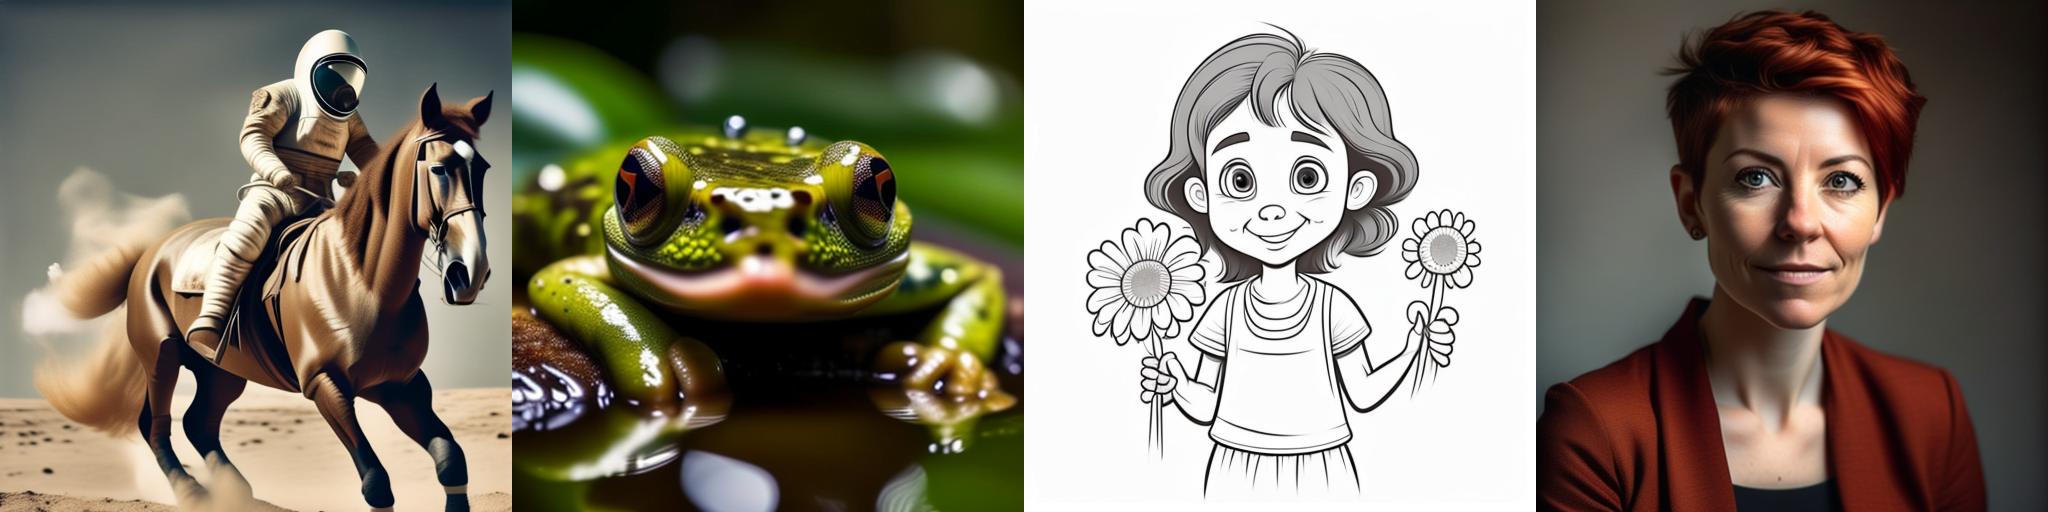

In [8]:
# generate image
images = ip_model.generate(clip_image_embeds=clip_image_embeds, num_samples=1, width=512, height=512, num_inference_steps=50, seed=42)
image_grid(images, 1, 4)